In [3]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Creates a table of Q_values (state-action) initialized with zeros
# Initialize Q(s, a), for all s ∈ S, a ∈ A(s), arbitrarily, and Q(terminal-state, ·) = 0.
def createQ_table(rows = 4, cols = 12):
    """
    Implementation of creating a table for the Q(s, a) 'value state-action pair'

    Args:
        rows -- type(int) Number of rows the simple grid world
        cols -- type(int) Number of columns in the simple grid world

    Returns:
        q_table -- type(np.array) 2D representation of state-action pair table
                                     Rows are actions and columns are the states.
    """
    # initialize the q_table with all zeros for each state and action
    q_table = np.zeros((4, cols * rows))

    # define an action dictionary to access corresponding state-action pairs fast
    action_dict =  {"UP": q_table[0, :],"LEFT": q_table[1, :], "RIGHT": q_table[2, :], "DOWN": q_table[3, :]}

    return q_table

In [5]:
# Choosing action using policy
# Sutton's code pseudocode: Choose A from S using policy derived from Q (e.g., ε-greedy)
# %10 exploration to avoid stucking at a local optima
def epsilon_greedy_policy(state, q_table, epsilon = 0.1):
    """
    Epsilon greedy policy implementation takes the current state and q_value table
    Determines which action to take based on the epsilon-greedy policy

    Args:
        epsilon -- type(float) Determines exploration/explotion ratio
        state -- type(int) Current state of the agent value between [0:47]
        q_table -- type(np.array) Determines state value

    Returns:
        action -- type(int) Choosen function based on Q(s, a) pairs & epsilon
    """
    # choose a random int from an uniform distribution [0.0, 1.0)
    decide_explore_exploit  = np.random.random()

    if(decide_explore_exploit < epsilon):
        action = np.random.choice(4) # UP = 0, LEFT = 1, RIGHT = 2, DOWN = 3
    else:
        action = np.argmax(q_table[:, state]) # Choose the action with largest Q-value (state value)

    return action

In [6]:
def move_agent(agent, action):
    """
    Moves the agent based on action to take

    Args:
        agent -- type(tuple) x, y coordinate of the agent on the grid
        action -- type(int) updates agent's position

    Returns:
        agent -- type(tuple) new coordinate of the agent
    """
    # get position of the agent
    (posX , posY) = agent
    # UP
    if ((action == 0) and posX > 0):
        posX = posX - 1
    # LEFT
    if((action == 1) and (posY > 0)):
        posY = posY - 1
    # RIGHT
    if((action == 2) and (posY < 11)):
        posY = posY + 1
    # DOWN
    if((action) == 3 and (posX < 3)):
        posX = posX + 1
    agent = (posX, posY)

    return agent

In [7]:
def get_state(agent, q_table):
    """
    Determine the state and state value given agent's position

    Args:
        agent -- type(tuple) x, y coordinate of the agent on the grid
        q_table -- type(np.array) Determines state value

    Returns:
        state -- type(int) state value between [0,47]
        max_state_value -- type(float) maximum state value at the position of the agent
    """
    # get position of the agent
    (posX , posY) = agent

    # obtain the state value
    state = 12 * posX + posY

    # get maximum state value from the table
    state_action = q_table[:, int(state)]
    maximum_state_value = np.amax(state_action) # return the state value with for the highest action
    return state, maximum_state_value

In [8]:
def get_reward(state):
    """
    Function returns reward in the given state

    Args:
        state -- type(int) state value between [0,47]

    Returns:
        reward -- type(int) Reward in the corresponding state
        game_end -- type(bool) Flag indicates game end (falling out of cliff / reaching the goal)
    """
    # game continues
    game_end = False
    # all states except cliff have -1 value
    reward = -1
    # goal state
    if(state == 47):
        game_end = True
        reward = 10
    # cliff
    if(state >= 37 and state <= 46):
        game_end = True
        # Penalize the agent if agent encounters a cliff
        reward = -100

    return reward, game_end

In [9]:
def update_qTable(q_table, state, action, reward, next_state_value, gamma_discount = 0.9, alpha = 0.5):
    """
    Update the q_table based on observed rewards and maximum next state value
    Sutton's Book pseudocode:  Q(S, A) <- Q(S, A) + [alpha * (reward + (gamma * maxValue(Q(S', A'))) -  Q(S, A) ]

    Args:
        q_table -- type(np.array) Determines state value
        state -- type(int) state value between [0,47]
        action -- type(int) action value [0:3] -> [UP, LEFT, RIGHT, DOWN]
        reward -- type(int) reward in the corresponding state
        next_state_value -- type(float) maximum state value at next state
        gamma_discount -- type(float) discount factor determines importance of future rewards
        alpha -- type(float) controls learning convergence

    Returns:
        q_table -- type(np.array) Determines state value
    """
    update_q_value = q_table[action, state] + alpha * (reward + (gamma_discount * next_state_value) - q_table[action, state])
    q_table[action, state] = update_q_value

    return q_table

In [10]:
def qlearning(num_episodes = 500, gamma_discount = 0.9, alpha = 0.5, epsilon = 0.1):
    """
    Implementation of q-learning algorithm. (Sutton's book)

    Args:
        num_episodes -- type(int) number of games to train agent
        gamma_discount -- type(float) discount factor determines importance of future rewards
        alpha -- type(float) determines convergence rate of the algorithm (can think as updating states fast or slow)
        epsilon -- type(float) explore/ exploit ratio (exe: default value 0.1 indicates %10 exploration)

    Returns:
        q_table -- type(np.array) Determines state value
        reward_cache -- type(list) contains cumulative_reward
    """
    # initialize all states to 0
    # Terminal state cliff_walking ends
    reward_cache = list()
    step_cache = list()
    q_table = createQ_table()
    agent = (3, 0) # starting from left down corner
    # start iterating through the episodes
    for episode in range(0, num_episodes):
        env = np.zeros((4, 12))
        env = visited_env(agent, env)
        agent = (3, 0) # starting from left down corner
        game_end = False
        reward_cum = 0 # cumulative reward of the episode
        step_cum = 0 # keeps number of iterations untill the end of the game
        while(game_end == False):
            # get the state from agent's position
            state, _ = get_state(agent, q_table)
            # choose action using epsilon-greedy policy
            action = epsilon_greedy_policy(state, q_table)
            # move agent to the next state
            agent = move_agent(agent, action)
            step_cum += 1
            env = visited_env(agent, env) # mark the visited path
            # observe next state value
            next_state, max_next_state_value = get_state(agent, q_table)
            # observe reward and determine whether game ends
            reward, game_end = get_reward(next_state)
            reward_cum += reward
            # update q_table
            q_table = update_qTable(q_table, state, action, reward, max_next_state_value, gamma_discount, alpha)
            # update the state
            state = next_state
        reward_cache.append(reward_cum)
        if(episode > 498):
            print("Agent trained with Q-learning after 500 iterations")
            print(env) # display the last 2 path agent takes
        step_cache.append(step_cum)
    return q_table, reward_cache, step_cache

In [11]:
def sarsa(num_episodes = 500, gamma_discount = 0.9, alpha = 0.5, epsilon = 0.1):
    """
    Implementation of SARSA algorithm. (Sutton's book)

    Args:
        num_episodes -- type(int) number of games to train agent
        gamma_discount -- type(float) discount factor determines importance of future rewards
        alpha -- type(float) determines convergence rate of the algorithm (can think as updating states fast or slow)
        epsilon -- type(float) explore/ exploit ratio (exe: default value 0.1 indicates %10 exploration)

    Returns:
        q_table -- type(np.array) Determines state value
        reward_cache -- type(list) contains cumulative_reward
    """
    # initialize all states to 0
    # Terminal state cliff_walking ends
    q_table = createQ_table()
    step_cache = list()
    reward_cache = list()
    # start iterating through the episodes
    for episode in range(0, num_episodes):
        agent = (3, 0) # starting from left down corner
        game_end = False
        reward_cum = 0 # cumulative reward of the episode
        step_cum = 0 # keeps number of iterations untill the end of the game
        env = np.zeros((4, 12))
        env = visited_env(agent, env)
        # choose action using policy
        state, _ = get_state(agent, q_table)
        action = epsilon_greedy_policy(state, q_table)
        while(game_end == False):
            # move agent to the next state
            agent = move_agent(agent, action)
            env = visited_env(agent, env)
            step_cum += 1
            # observe next state value
            next_state, _ = get_state(agent, q_table)
            # observe reward and determine whether game ends
            reward, game_end = get_reward(next_state)
            reward_cum += reward
            # choose next_action using policy and next state
            next_action = epsilon_greedy_policy(next_state, q_table)
            # update q_table
            next_state_value = q_table[next_action][next_state] # differs from q-learning uses the next action determined by policy
            q_table = update_qTable(q_table, state, action, reward, next_state_value, gamma_discount, alpha)
            # update the state and action
            state = next_state
            action = next_action # differs q_learning both state and action must updated
        reward_cache.append(reward_cum)
        step_cache.append(step_cum)
        if(episode > 498):
            print("Agent trained with SARSA after 500 iterations")
            print(env) # display the last 2 path agent takes
    return q_table, reward_cache, step_cache

In [12]:
def visited_env(agent, env):
    """
        Visualize the path agent takes

    """
    (posY, posX) = agent
    env[posY][posX] = 1
    return env

In [13]:
def retrieve_environment(q_table, action):
    """
    Displays the environment state values for a specific action
    Implemented for debug purposes

    Args:
        q_table -- type(np.array) Determines state value
        action -- type(int) action value [0:3] -> [UP, LEFT, RIGHT, DOWN]
    """
    env = q_table[action, :].reshape((4, 12))
    print(env) # display environment values

In [14]:
def plot_cumreward_normalized(reward_cache_qlearning, reward_cache_SARSA):
    """
    Visualizes the reward convergence

    Args:
        reward_cache -- type(list) contains cumulative_reward
    """
    cum_rewards_q = []
    rewards_mean = np.array(reward_cache_qlearning).mean()
    rewards_std = np.array(reward_cache_qlearning).std()
    count = 0 # used to determine the batches
    cur_reward = 0 # accumulate reward for the batch
    for cache in reward_cache_qlearning:
        count = count + 1
        cur_reward += cache
        if(count == 10):
            # normalize the sample
            normalized_reward = (cur_reward - rewards_mean)/rewards_std
            cum_rewards_q.append(normalized_reward)
            cur_reward = 0
            count = 0

    cum_rewards_SARSA = []
    rewards_mean = np.array(reward_cache_SARSA).mean()
    rewards_std = np.array(reward_cache_SARSA).std()
    count = 0 # used to determine the batches
    cur_reward = 0 # accumulate reward for the batch
    for cache in reward_cache_SARSA:
        count = count + 1
        cur_reward += cache
        if(count == 10):
            # normalize the sample
            normalized_reward = (cur_reward - rewards_mean)/rewards_std
            cum_rewards_SARSA.append(normalized_reward)
            cur_reward = 0
            count = 0
    # prepare the graph
    plt.plot(cum_rewards_q, label = "q_learning")
    plt.plot(cum_rewards_SARSA, label = "SARSA")
    plt.ylabel('Cumulative Rewards')
    plt.xlabel('Batches of Episodes (sample size 10) ')
    plt.title("Q-Learning/SARSA Convergence of Cumulative Reward")
    plt.legend(loc='lower right', ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

In [15]:
def plot_number_steps(step_cache_qlearning, step_cache_SARSA):
    """
        Visualize number of steps taken
    """
    cum_step_q = []
    steps_mean = np.array(step_cache_qlearning).mean()
    steps_std = np.array(step_cache_qlearning).std()
    count = 0 # used to determine the batches
    cur_step = 0 # accumulate reward for the batch
    for cache in step_cache_qlearning:
        count = count + 1
        cur_step += cache
        if(count == 10):
            # normalize the sample
            normalized_step = (cur_step - steps_mean)/steps_std
            cum_step_q.append(normalized_step)
            cur_step = 0
            count = 0

    cum_step_SARSA = []
    steps_mean = np.array(step_cache_SARSA).mean()
    steps_std = np.array(step_cache_SARSA).std()
    count = 0 # used to determine the batches
    cur_step = 0 # accumulate reward for the batch
    for cache in step_cache_SARSA:
        count = count + 1
        cur_step += cache
        if(count == 10):
            # normalize the sample
            normalized_step = (cur_step - steps_mean)/steps_std
            cum_step_SARSA.append(normalized_step)
            cur_step = 0
            count = 0
    # prepare the graph
    plt.plot(cum_step_q, label = "q_learning")
    plt.plot(cum_step_SARSA, label = "SARSA")
    plt.ylabel('Number of iterations')
    plt.xlabel('Batches of Episodes (sample size 10) ')
    plt.title("Q-Learning/SARSA Iteration number untill game ends")
    plt.legend(loc='lower right', ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

In [16]:
def plot_qlearning_smooth(reward_cache):
    """
    Visualizes the reward convergence using weighted average of previous 10 cumulative rewards
    NOTE: Normalization gives better visualization

    Args:
        reward_cache -- type(list) contains cumulative_rewards for episodes
    """
    mean_rev = (np.array(reward_cache[0:11]).sum())/10
    # initialize with cache mean
    cum_rewards = [mean_rev] * 10
    idx = 0
    for cache in reward_cache:
        cum_rewards[idx] = cache
        idx += 1
        smooth_reward = (np.array(cum_rewards).mean())
        cum_rewards.append(smooth_reward)
        if(idx == 10):
            idx = 0

    plt.plot(cum_rewards)
    plt.ylabel('Cumulative Rewards')
    plt.xlabel('Batches of Episodes (sample size 10) ')
    plt.title("Q-Learning  Convergence of Cumulative Reward")
    plt.legend(loc='lower left', ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

In [17]:
def generate_heatmap(q_table):
    """
        Generates heatmap to visualize agent's learned actions on the environment
    """
    import seaborn as sns; sns.set()
    # display mean of environment values using a heatmap
    data = np.mean(q_table, axis = 0)
    print(data)
    data = data.reshape((4, 12))
    ax = sns.heatmap(np.array(data))
    return ax

Agent trained with SARSA after 500 iterations
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Agent trained with Q-learning after 500 iterations
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


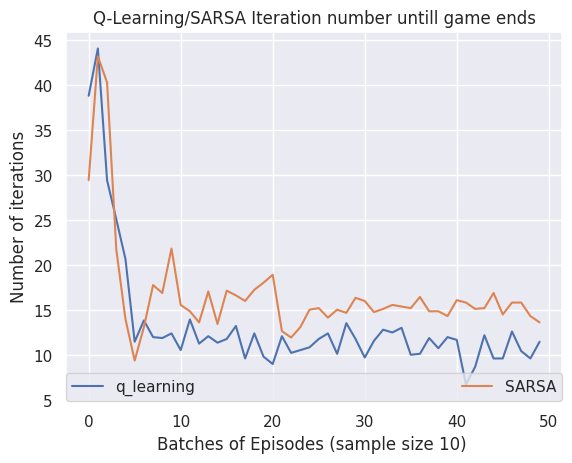

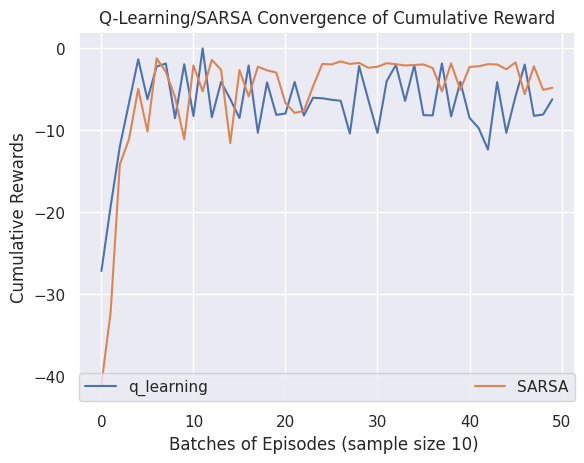

Visualize environment Q-learning
[-5.73053569e+00 -5.47502483e+00 -5.08353013e+00 -4.77449754e+00
 -4.36219148e+00 -3.69903930e+00 -2.89779470e+00 -2.03160112e+00
 -1.71358850e+00 -1.22648939e+00 -5.85761522e-01 -1.14718750e+00
 -5.39601117e+00 -4.69657016e+00 -4.53954103e+00 -3.99155109e+00
 -2.99937957e+00 -3.08770223e+00 -1.28004843e+00 -1.00044170e-01
  6.45914989e-01 -2.87698007e-03  1.19852452e+00  6.80603435e-01
 -4.47838404e+00 -2.79687128e+01 -2.74478423e+01 -2.68636111e+01
 -2.62131708e+01 -2.55374207e+01 -2.47770465e+01 -2.38837981e+01
 -2.21839393e+01 -2.19045331e+01 -2.07522152e+01  6.79399672e+00
 -2.85465868e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
Axes(0.125,0.11;0.62x0.77)
Visualize SARSA
[ -6.69299486  -6.1686545   -5.86063132  -5.17941289  -4.64015444
  -3.91514395  -3.0877163   -2.4865526   -1.29300736   0.18927052
   1.628694

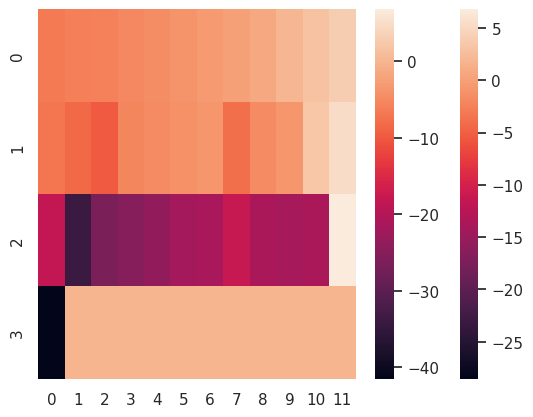

In [18]:
def main():
    # Learn state dynamics obtain cumulative rewards for 500 episodes
    #SARSA
    q_table_SARSA, reward_cache_SARSA, step_cache_SARSA = sarsa()
    # QLEARNING
    q_table_qlearning, reward_cache_qlearning, step_cache_qlearning = qlearning()
    plot_number_steps(step_cache_qlearning, step_cache_SARSA)
    # Visualize the result
    plot_cumreward_normalized(reward_cache_qlearning,reward_cache_SARSA)

    # generate heatmap
    print("Visualize environment Q-learning")
    ax_q = generate_heatmap(q_table_qlearning)
    print(ax_q)

    print("Visualize SARSA")
    ax_SARSA = generate_heatmap(q_table_SARSA)
    print(ax_SARSA)

    # Debug method giving information about what are some states for environment
    want_to_see_env = False
    if(want_to_see_env):
        print("UP")
        retrieve_environment(q_table_qlearning, 0)
        print("LEFT")
        retrieve_environment(q_table_qlearning, 1)
        print("RIGHT")
        retrieve_environment(q_table_qlearning, 2)
        print("DOWN")
        retrieve_environment(q_table_qlearning, 3)
    want_to_see_env = False
    if(want_to_see_env):
        print("UP")
        retrieve_environment(q_table_SARSA, 0)
        print("LEFT")
        retrieve_environment(q_table_SARSA, 1)
        print("RIGHT")
        retrieve_environment(q_table_SARSA, 2)
        print("DOWN")
        retrieve_environment(q_table_SARSA, 3)

if __name__ == "__main__":
    # call main function to execute grid world
    main()